<a href="https://colab.research.google.com/github/helainytorres/RedesNeurais/blob/main/2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
colab = True
if colab:
    !git clone https://github.com/mdrs-thiago/PUC_Redes_Neurais
    import os
    os.chdir('/content/PUC_Redes_Neurais/pos_grad/lista 1')

Cloning into 'PUC_Redes_Neurais'...
remote: Enumerating objects: 321, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 321 (delta 124), reused 242 (delta 48), pack-reused 0
Receiving objects: 100% (321/321), 3.99 MiB | 17.25 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader
import torch.nn.functional as F
from typing import Tuple, Dict, List
from tqdm.notebook import tqdm
import sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

binary=True

In [4]:
class CustomDataset(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

In [27]:
def plots(history):
# plot graphs
 #fig = plt.figure(figsize = (10,20))
 fig = plt.figure()
 plt.subplot(1,2,1)
 #plt.plot(history['loss_train'], label = 'Treino')
 #plt.plot(history['loss_val'], label = 'Validação')
 plt.plot(history['loss_train'])
 plt.plot(history['loss_val'])
 plt.xlabel('Épocas', size = 15)
 plt.ylabel('Custo', size = 15)
 plt.xticks(size = 15)
 plt.yticks(size = 15)
 # plt.legend(prop = {'size': 15})
 plt.subplot(1,2,2)
 # plt.plot(history['acc_train'], label = 'Treino')
 #plt.plot(history['acc_val'], label = 'Validação')
 plt.plot(history['acc_train'])
 plt.plot(history['acc_val'])
 plt.xlabel('Épocas', size = 15)
 plt.ylabel('Acuracidade', size = 15)
 plt.xticks(size = 15)
 plt.yticks(size = 15)
 #plt.legend(prop = {'size': 15})
 plt.tight_layout()
 plt.show()

In [6]:
#Definindo a rede neural

class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar
  o mesmo modelo com apenas uma linha.

  Parâmetros de entrada:
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida.
  - hidden_activation: Função de ativação para cada camada escondida. Aceita
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]

    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h)
    y = self.fc2(h1)
    #y = self.out(h2)
    return y

  def predict(self, x, binary=True):
    y_hat = self.forward(x)

    if binary:
      y_pred = torch.round(torch.sigmoid(y_hat))
      y_pred = y_pred.detach().numpy()
    else:
      y_pred = torch.argmax(y_hat, dim=1)

    return y_pred


In [7]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [8]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

def evaluate(model: torch.nn.Module, val_set: Tuple[torch.tensor, torch.tensor],
            criterion: torch.nn.Module, binary:bool =True) -> Tuple[torch.tensor, float, float]:
    """
    Evaluates a Pytorch model on a given dataset.
    Parameters:
    model (torch.nn.Module): The model to be evaluated
    data (tuple): A tuple containing the data and labels
    criterion (torch.nn.Module): The loss function to be used
    binary (bool): Boolean indicating whether the task is binary classification or not. Default: True
    Returns:
    tuple: A tuple containing predicted labels, loss, and accuracy
    """

    X = val_set.X_data
    y = val_set.y_data

    with torch.no_grad():
        y_pred = model(X)
    loss = criterion(y_pred, y)
    if binary:
        acc = binary_acc(y_pred, y)
    else:
        acc = accuracy(y_pred, y)
    y_pred = torch.argmax(y_pred, dim=1)

    return y_pred, loss.item(), acc.item()

def train(model: torch.nn.Module , train_loader: torch.utils.data.DataLoader,
         val_set: Tuple[torch.Tensor, torch.Tensor], epochs: int, device: torch.device,
         lr: float, binary: bool = True, skip: int = 1) -> Tuple[Dict[str, List[float]], torch.Tensor]:
    """
    Trains a Pytorch model on a given training data.

    Parameters:
    model (torch.nn.Module): The model to be trained
    train_loader (DataLoader): The training data in the form of a Pytorch DataLoader
    val_set (tuple): A tuple containing the validation data and labels
    epochs (int): The number of times the training data should be passed through the model
    device (str or torch.device): The device on which to perform the computations (e.g. 'cpu' or 'cuda')
    lr (float): The learning rate for the optimizer
    binary (bool): Boolean indicating whether the task is binary classification or not. Default: True
    skip (int): The number of epochs after which the training and validation results will be printed. Default: 1

    Returns:
    tuple: A tuple containing the training history and the predicted labels after training
    """

    early_stopping = EarlyStopping(patience=5,verbose=True)

    if binary:
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()

    print('my train')
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    history = {'acc_train' : [], 'loss_train': [], 'acc_val': [], 'loss_val': []}

    for e in tqdm(range(1, epochs+1)):

        y_hat = np.array([])

        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X, y = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X)

            loss = criterion(y_pred, y)
            if binary:
                acc = binary_acc(y_pred,y)
            else:
                acc = accuracy(y_pred, y)

            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()
            train_epoch_acc += acc.item()
            y_p = torch.argmax(y_pred, dim=1)
            y_hat = np.concatenate((y_hat, y_p))


        model.eval()
        _, val_loss, val_acc = evaluate(model, val_set, criterion, binary=binary)

        history['acc_train'].append(train_epoch_acc/len(train_loader))
        history['loss_train'].append(train_epoch_loss/len(train_loader))
        history['acc_val'].append(val_acc)
        history['loss_val'].append(val_loss)


        #Earling Stopping encontrado
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
          print("Early stopping")
          break

        if e%skip == 0:
            print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.3f} | Val Loss: {val_loss:.4f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_acc:.4f}')
    return history, y_hat


In [9]:
from typing import List, Any
def plot_confusion_matrix(cm: Any,
                          target_names: List[str] = None,
                          title: str ='Confusion matrix',
                          cmap: Any = None,
                          normalize: bool = False):
    """
    given a sklearn confusion matrix (cm), make a nice plot
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if target_names is None:
        target_names = [i for i in range(cm.shape[0])]

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def piecewise_norm(vec,val,n):
    assert val > min(vec)

    return np.where(vec < val, n*(vec - min(vec))/(val - min(vec)), (1-n)*(vec - val)/(max(vec) - val) + n)

def transform_data(dataset: pd.DataFrame, normalize: bool = True):
    """
    Transforms data from a pandas DataFrame into a new DataFrame.
    Parameters:
        dataset (pd.DataFrame): The input dataset
        normalize (bool): Boolean indicating whether to normalize numerical data. Default: True
    Returns:
        pd.DataFrame: The transformed dataframe
    """

    new_df = pd.DataFrame()

    #Varre todas as colunas do dataframe.
    for name, name_type in dataset.dtypes.items():

        if name == 'target':
            new_df[name] = dataset[name].values

        #Tratamento de dados utilizando o atributo categórico. No caso, é utilizada a codificação 1 of N.
        elif name_type == object:
            raw_data = dataset[name].values
            d_encoder = LabelEncoder()
            d_encoder.fit(raw_data)
            d_encoded = d_encoder.transform(raw_data)
            #dummy_y = to_categorical(d_encoded)
            dim = len(d_encoder.classes_)
            dummy_y = np.eye(dim)[d_encoded]

            for (j,k) in enumerate(d_encoder.classes_):
                new_df[f'{name}_{k}'] = dummy_y[:,j].astype('int')


        #Caso numérico, utilizando normalização min-max
        else:
            raw_data = dataset[name].values
            if normalize:
                new_df[name] = (raw_data - min(raw_data))/(max(raw_data) - min(raw_data))
            else:
                new_df[name] = raw_data


    return new_df

In [10]:
from utils import CustomDataset, transform_data, plot_confusion_matrix
#from model_utils import train

In [11]:
file = '/content/drive/MyDrive/data21.csv'
data = pd.read_csv(file,sep=';',low_memory=False)

In [12]:
data.groupby(by='EVOLUCAO').count()
data = sklearn.utils.shuffle(data).reset_index(drop=True) #embaralhar

In [13]:
#Dividindo dados
dataset_positive = data.loc[data['EVOLUCAO'] == 0.0] #299635 dados
dataset_negative = data.loc[data['EVOLUCAO'] == 1.0] #159243 dados


In [14]:
dataset_positive = dataset_positive.reset_index(drop=True)
dataset_negative = dataset_negative.reset_index(drop=True)

In [15]:
data_positive_new = dataset_positive.loc[0:100000,:] # apenas 1000000 colunas para se igualar ao dataset positivo
data_negative_new = dataset_negative.loc[0:100000,:] # apenas 1000000 colunas para se igualar ao dataset negativo
newdata = pd.concat([data_positive_new, data_negative_new])
newdata = sklearn.utils.shuffle(newdata).reset_index(drop=True) #embaralhar


In [16]:
data_positive_res = dataset_positive.loc[100001:299635,:] # apenas 1000000 colunas para se igualar ao dataset positivo
data_negative_res = dataset_negative.loc[100001:159243,:] # apenas 1000000 colunas para se igualar ao dataset negativo
newdata_res = pd.concat([data_positive_res, data_negative_res])
newdata_res = sklearn.utils.shuffle(newdata_res).reset_index(drop=True) #embaralhar


In [17]:
x_train = newdata.drop("EVOLUCAO",axis=1)#tranasforma as variáveis de entrada em float, exceto a ultima (target)
target_train = newdata[['EVOLUCAO']] #Vetor de saida (output), para comparação

x_test = newdata_res.drop("EVOLUCAO",axis=1)#tranasforma as variáveis de entrada em float, exceto a ultima (target)
target_test = newdata_res[['EVOLUCAO']] #Vetor de saida (output), para comparação

In [ ]:
data_positive_res

In [18]:
encoder = LabelEncoder() #codificador de dados
y_train = encoder.fit_transform(target_train) # binariza a saida
y_test = encoder.fit_transform(target_test) # binariza a saida

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#x = data.drop("EVOLUCAO",axis=1)#tranasforma as variáveis de entrada em float, exceto a ultima (target)
#target = data[['EVOLUCAO']] #Vetor de saida (output), para comparação

In [ ]:
#encoder = LabelEncoder() #codificador de dados
#y = encoder.fit_transform(target) # binariza a saida

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#x = data.drop("EVOLUCAO",axis=1).astype('float')#tranasforma as variáveis de entrada em float, exceto a ultima (target)
#target = data[['EVOLUCAO']].astype('float') #Vetor de saida (output), para comparação

In [19]:
n_input = x_train.shape[1]
n_output = 1
binary = True
batch_size = 32  #definindo batchs
epochs = 1000  #definindo épocas
lr = 0.01 #taxa de aprendizado
hidden_neurons=5

In [20]:
#X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.2,random_state=42)

In [21]:
#Para o caso binário
train_dataset = CustomDataset(torch.from_numpy(X_train.to_numpy()).float(), torch.from_numpy(y_train).float().unsqueeze(1))
val_dataset = CustomDataset(torch.from_numpy(X_val.to_numpy()).float(), torch.from_numpy(y_val).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(x_test.to_numpy()).float(), torch.from_numpy(y_test).float().unsqueeze(1))


train_loader = DataLoader(dataset=train_dataset,batch_size=32)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [22]:
# Criando o modelo de rede
lr = 0.05 #taxa de aprendizado
hidden_neurons=5
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

accuracy = []
precision = []
f1score = []
recall = []



In [23]:
history, y_hat = train(model, train_loader, val_dataset, epochs=500, lr=lr, device=device, binary=True)

my train


  0%|          | 0/500 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.676668).  Saving model ...
Epoch 001: | Train Loss: 0.662 | Val Loss: 0.6767 | Train Acc: 59.5915| Val Acc: 57.0000
Validation loss decreased (0.676668 --> 0.673476).  Saving model ...
Epoch 002: | Train Loss: 0.658 | Val Loss: 0.6735 | Train Acc: 60.2715| Val Acc: 57.0000
EarlyStopping counter: 1 out of 5
Epoch 003: | Train Loss: 0.656 | Val Loss: 0.6745 | Train Acc: 60.3785| Val Acc: 57.0000
Validation loss decreased (0.673476 --> 0.672923).  Saving model ...
Epoch 004: | Train Loss: 0.656 | Val Loss: 0.6729 | Train Acc: 60.4247| Val Acc: 58.0000
Validation loss decreased (0.672923 --> 0.668883).  Saving model ...
Epoch 005: | Train Loss: 0.655 | Val Loss: 0.6689 | Train Acc: 60.4293| Val Acc: 59.0000
Validation loss decreased (0.668883 --> 0.668426).  Saving model ...
Epoch 006: | Train Loss: 0.654 | Val Loss: 0.6684 | Train Acc: 60.5123| Val Acc: 59.0000
EarlyStopping counter: 1 out of 5
Epoch 007: | Train Loss: 0.653 | Val Loss: 0.6690 | Train 

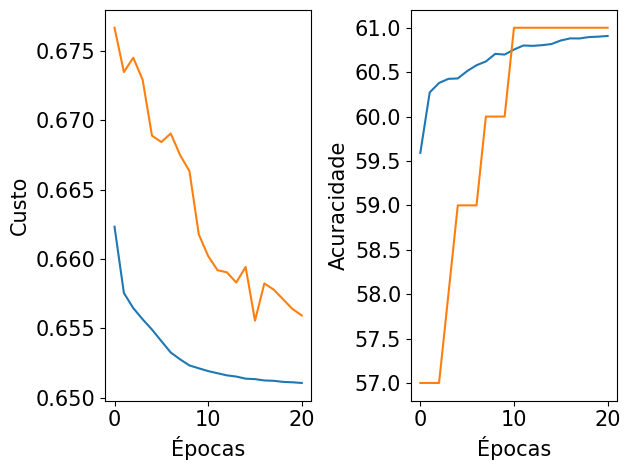

In [28]:
plots(history)   #Treino Azul #validacao vermelho

In [29]:
from sklearn import svm
#SVM Classificador
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [ ]:
len(y_hat)

160001

In [ ]:
# Importa os pacotes
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

accuracy =accuracy_score(y_test, y_hat)
precision = precision_score(y_test, y_hat,average='weighted')
f1score = f1_score(y_test, y_hat,average='weighted')
recall = recall_score(y_test, y_hat,average='weighted')

print(accuracy)
print(precision)
print(f1score)
print(recall)

In [ ]:
cm = confusion_matrix(y_test, y_hat)

In [ ]:
plots(history)

In [ ]:
# Randon Forest
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

rf = RandomForestClassifier()
rf.fit(X_train, y_train)



RandomForestClassifier()

In [ ]:
y_pred = rf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5802854928626784


In [ ]:
#########################################################

In [ ]:
#SVN

from sklearn import svm
from sklearn.metrics import roc_auc_score,accuracy_score
#SVM Classificador
modelSVC = svm.SVC(random_state=50,gamma=1)
modelSVC.fit(X_train, y_train)
pred = modelSVC.predict(X_val)
accuracy = accuracy_score(y_val, pred)
print("Accuracy:", accuracy)
